d:\proiecte cc++\github\uni-ml-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9696 - loss: 0.1016 - val_accuracy: 0.9733 - val_loss: 0.0680
Epoch 2/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9723 - loss: 0.0701 - val_accuracy: 0.9733 - val_loss: 0.0677
Epoch 3/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9726 - loss: 0.0694 - val_accuracy: 0.9733 - val_loss: 0.0678
Epoch 4/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9723 - loss: 0.0698 - val_accuracy: 0.9733 - val_loss: 0.0673
Epoch 5/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9723 - loss: 0.0694 - val_accuracy: 0.9733 - val_loss: 0.0674
Epoch 6/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9726 - loss: 0.0691 - val_accuracy: 0.9734 - val_loss: 0.0675
Epoch 7/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9723 - loss: 0.0704 - val_accuracy: 0.9734 - val_loss: 0.0672
Epoch 8/15
1170/1170 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9725 - loss: 0.0695 -

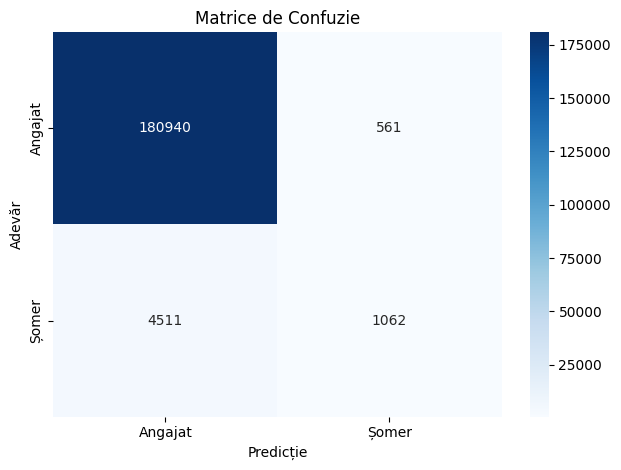

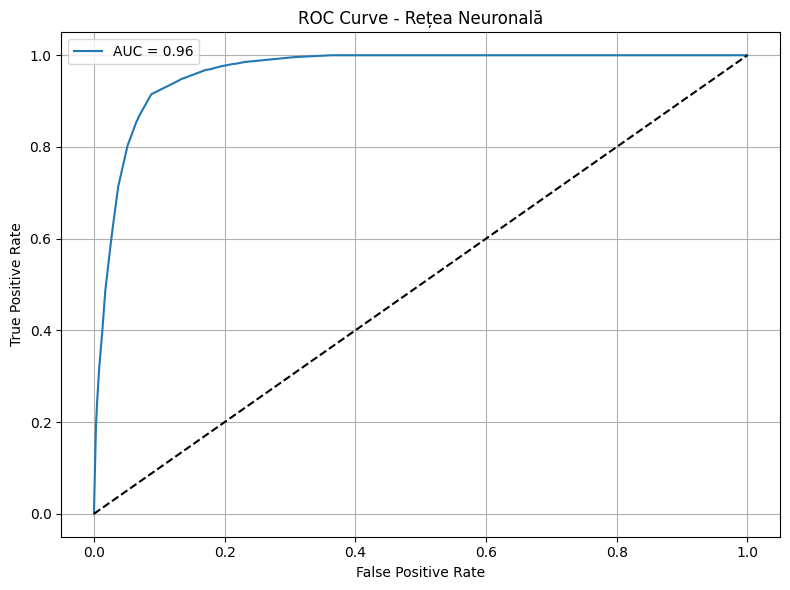

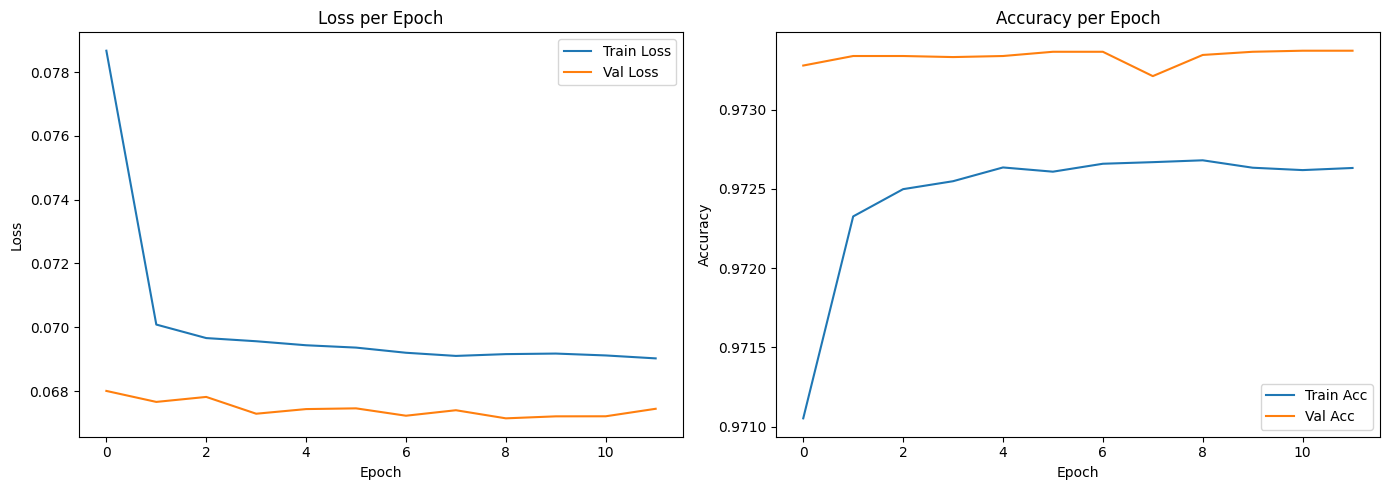

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Încarcă datele ===
dfs = []
for year in ['2010', '2011', '2012', '2013']:
    df = pd.read_csv(f"../data/raw/RO_LFS_{year}_Y.csv", low_memory=False)
    df['YEAR'] = int(year)
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# === 2. Prelucrare ===
features = ['SEX', 'AGE', 'EDUCSTAT', 'DEGURBA', 'STAPRO', 'TEMP', 'FTPT', 'COURATT']
target = 'ILOSTAT'

data = data[features + [target]].copy()
data = data[data[target].notna()]
data[target] = (data[target] == 2).astype(int)
data.dropna(subset=features + [target], inplace=True)
data_encoded = pd.get_dummies(data, columns=features, drop_first=True)

X = data_encoded.drop(columns=[target])
y = data_encoded[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 3. Callback: Salvează imagini ale greutăților ===
class WeightVisualizerCallback(tf.keras.callbacks.Callback):
    def __init__(self, output_dir="weights_viz"):
        super().__init__()
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        weights, biases = self.model.layers[0].get_weights()

        plt.figure(figsize=(12, 6))
        plt.imshow(weights, aspect='auto', cmap='coolwarm')
        plt.colorbar(label="Valoare greutate")
        plt.title(f"Greutăți strat 1 - Epoca {epoch + 1}")
        plt.xlabel("Neuroni ascunși")
        plt.ylabel("Feature-uri de input")
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/weights_epoch_{epoch+1:02d}.png")
        plt.close()

# === 4. Creează modelul ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
weight_viz = WeightVisualizerCallback()

# === 5. Antrenează modelul ===
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=512,
    callbacks=[early_stop, weight_viz],
    verbose=1
)

# === 6. Evaluați modelul ===
y_prob = model.predict(X_test_scaled).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Classification report & matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Angajat", "Șomer"], yticklabels=["Angajat", "Șomer"])
plt.title("Matrice de Confuzie")
plt.xlabel("Predicție")
plt.ylabel("Adevăr")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Rețea Neuronală")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss & accuracy
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
